In [ ]:
pip install symspellpy

In [ ]:
pip install Sastrawi

In [ ]:
pip install WordCloud

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

import re 
import string

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory # lemmatization
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory 

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize #tokenization word
from nltk.probability import FreqDist # requesncy word
from nltk.corpus import stopwords # filtering
from symspellpy import SymSpell

from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec

import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from collections import Counter
import gzip
from urllib.request import urlopen

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU, Dropout

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential




import tensorflow_hub as hub

pd.get_option("display.max_columns")

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df_alay = pd.read_csv('new_kamusalay.csv', encoding="latin-1")

df = pd.read_csv("data.csv", encoding='latin-1')
df.head(5)

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [ ]:
df_1 = df.copy()

In [ ]:
df_1['label'] = df_1[['HS_Individual', 'HS_Group', 'HS_Religion',
       'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak',
       'HS_Moderate', 'HS_Strong']].values.tolist()

In [ ]:
df_1['label'] = np.array(df_1['label'])

In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          13169 non-null  object
 1   HS             13169 non-null  int64 
 2   Abusive        13169 non-null  int64 
 3   HS_Individual  13169 non-null  int64 
 4   HS_Group       13169 non-null  int64 
 5   HS_Religion    13169 non-null  int64 
 6   HS_Race        13169 non-null  int64 
 7   HS_Physical    13169 non-null  int64 
 8   HS_Gender      13169 non-null  int64 
 9   HS_Other       13169 non-null  int64 
 10  HS_Weak        13169 non-null  int64 
 11  HS_Moderate    13169 non-null  int64 
 12  HS_Strong      13169 non-null  int64 
 13  label          13169 non-null  object
dtypes: int64(12), object(2)
memory usage: 1.4+ MB


In [ ]:
df_1 = df_1[['Tweet', 'label']].copy()

In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   13169 non-null  object
 1   label   13169 non-null  object
dtypes: object(2)
memory usage: 205.9+ KB


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_1['Tweet'], df_1['label'], test_size=0.1)

In [ ]:
print(f'train : {X_train.shape}')
print(f'test : {X_test.shape}')

train : (11852,)
test : (1317,)


In [ ]:
#train
X_train = pd.DataFrame(X_train).reset_index()
y_train = pd.DataFrame(y_train).reset_index()

In [ ]:
#test
X_test = pd.DataFrame(X_test).reset_index()
y_test = pd.DataFrame(y_test).reset_index()

In [ ]:
# menyatukan train
df_train = pd.merge(X_train, y_train, on='index', how='right')

# menyatukan test
df_test = pd.merge(X_test, y_test, on='index', how='right')

In [ ]:
#kamus tambahan
df_alay.rename(columns={'anakjakartaasikasik':'original', 'anak jakarta asyik asyik' : 'replace'}, inplace=True)
df_alay.head()

,original,replace
0,pakcikdahtua,pak cik sudah tua
1,pakcikmudalagi,pak cik muda lagi
2,t3tapjokowi,tetap jokowi
3,3x,tiga kali
4,aamiin,amin


In [ ]:
# filtering 

def lower(text):
  return text.lower()

def case_folding(text):
  #text  = re.sub('[^\x00-\x7f]','',text)
  text = re.sub(r"http\S+",' ',text)
  text  = re.sub(r"\\n",' ', text.strip())
  text = (re.sub(r"\\x[A-Za-z0-9./]+", r' ', text))
  text = re.sub(r'rt', ' ', text)
  text = re.sub(r'user', ' ', text)
  text = re.sub("#.+\S",' ',text)
  text = re.sub(r"\b(?=[wk]*w)w*k[wk]*\b | wkwk", ' ', text)
  text = re.sub(r"wkwk", '', text)
  text = re.sub(r"\b(?=[ha]*h)h*a[ha]*\b | haha", ' ', text)
  text = re.sub(r'\d', ' ',text)
  return text

def punctuation(text):
  text = text.translate(str.maketrans(" "," ", string.punctuation))
  return text

alay_dict = dict(zip(df_alay['original'], df_alay['replace']))
def replace(text):
  return ' '.join(alay_dict[word] if word in alay_dict else word for word in text.split(' '))

def strip(text):
  text = text.strip()
  return text

def preprocess_filter(text):
  text = lower(text)
  text = case_folding(text)
  text = punctuation(text)
  text = replace(text)
  text = strip(text)
  #text = emoticon(text)
  return text

In [ ]:
df_train['text'] = df_train['Tweet'].apply(preprocess_filter)
df_train[['Tweet','text']].head(10)

,Tweet,text
0,gw suka kontol lo beb :*',gue suka kontol kamu sayang
1,USER Gilaaaa lu ndro___pelepasa\xc3\xb1 saham ...,gila kamu dropelepasa saham disamakan dengan...
2,Sampai sekarang aku tak jumpa lagi maklumat pa...,sampai sekarang aku tak jumpa lagi maklumat pa...
3,RT USER Pak Anies n pak Sandi..... mana kerjam...,pak anies dan pak sandi mana kerjamu wkwk belu...
4,USER USER Inilah efek ajaran bani cingkrang ji...,inilah efek ajaran bani cingkrang jidat hitam ...
5,"Silahkan duduk ""Ko"", kata si mba nya. Tidak ha...",silakan duduk kok kata sih mbak nya tidak hany...
6,USER USER \xc2\xab diem lu buaya.',diam kamu buaya
7,USER Yg penting gk seasem kebijakan rezim si d...,yang penting tidak seasam kebijakan rezim sih ...
8,Capres RI 1 nih pintar dan pro wong cillik dan...,calon presiden ri nih pintar dan pro orang k...
9,"""...Jadi biang kegaduhannya itu PKS. Saya sih ...",jadi biang kegaduhannya itu partai keadilan se...


In [ ]:
# tokenizer word
def tokenize_word(text):
  text = word_tokenize(text)
  return text

df_train['token_word'] = df_train['text'].apply(tokenize_word)

In [ ]:
# jumlah kata dalam kalimat kalimat
list_count = []
for i in df_train['token_word']:
    list_count.append(len(i))

In [ ]:
df_count = pd.DataFrame(list_count, columns=['count_word']).reset_index()
df_count.head()

,index,count_word
0,0,5
1,1,17
2,2,32
3,3,16
4,4,9


In [ ]:
df_train = df_train.reset_index()
df_train.drop(columns=['index'], axis=1,inplace=True)
df_train.rename(columns={'level_0' : 'index'}, inplace=True)

In [ ]:
df_train = pd.merge(df_train, df_count, on='index', how='right')

In [ ]:
df_hs = df_train[['text', 'token_word', 'count_word','label']].copy()

df_hs.head(10)

,text,token_word,count_word,label
0,gue suka kontol kamu sayang,"[gue, suka, kontol, kamu, sayang]",5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,gila kamu dropelepasa saham disamakan dengan...,"[gila, kamu, dropelepasa, saham, disamakan, de...",17,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]"
2,sampai sekarang aku tak jumpa lagi maklumat pa...,"[sampai, sekarang, aku, tak, jumpa, lagi, makl...",32,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,pak anies dan pak sandi mana kerjamu wkwk belu...,"[pak, anies, dan, pak, sandi, mana, kerjamu, w...",16,"[1, 0, 0, 0, 0, 0, 1, 1, 0, 0]"
4,inilah efek ajaran bani cingkrang jidat hitam ...,"[inilah, efek, ajaran, bani, cingkrang, jidat,...",9,"[0, 1, 1, 0, 0, 0, 0, 0, 1, 0]"
5,silakan duduk kok kata sih mbak nya tidak hany...,"[silakan, duduk, kok, kata, sih, mbak, nya, ti...",10,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
6,diam kamu buaya,"[diam, kamu, buaya]",3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
7,yang penting tidak seasam kebijakan rezim sih ...,"[yang, penting, tidak, seasam, kebijakan, rezi...",9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
8,calon presiden ri nih pintar dan pro orang k...,"[calon, presiden, ri, nih, pintar, dan, pro, o...",12,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
9,jadi biang kegaduhannya itu partai keadilan se...,"[jadi, biang, kegaduhannya, itu, partai, keadi...",45,"[0, 1, 0, 0, 0, 0, 1, 0, 1, 0]"


In [ ]:
count_perword = pd.DataFrame(df_hs['count_word'].value_counts()).reset_index()
count_perword.rename(columns={'index':'jum_kata', 'count_word':'quantity'}, inplace=True)
count_perword.head()

,jum_kata,quantity
0,9,527
1,6,525
2,10,518
3,7,503
4,8,502


In [ ]:
%matplotlib inline
fig = px.bar(count_perword.head(),
             x='jum_kata',
             y='quantity',
             color='quantity',
             title='quantity jumlah perkata dalam kalimat')

fig.show()

In [ ]:
#kata paling banyak
list_word=[]
for i in df_hs['token_word']:
  for u in i:
    list_word.append(u)

fdict = FreqDist(list_word)
fdict.most_common(10)

[('yang', 4398),
 ('tidak', 2813),
 ('di', 2770),
 ('dan', 2725),
 ('itu', 1852),
 ('kamu', 1595),
 ('ini', 1415),
 ('indonesia', 1315),
 ('ada', 1290),
 ('sudah', 1190)]

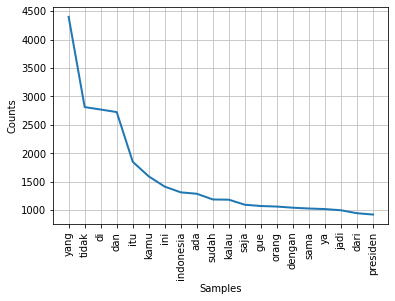

In [ ]:
fdict.plot(20)
plt.show()

In [ ]:
# lemmatization
fectory_stemmer = StemmerFactory()
stemmer_fec = fectory_stemmer.create_stemmer()

def lemma(text):
  text = stemmer_fec.stem(text)
  return text

df_hs['text_lemma'] = df_hs['text'].apply(lemma)

In [ ]:
df_hs.head()

,text,token_word,count_word,label,text_lemma
0,gue suka kontol kamu sayang,"[gue, suka, kontol, kamu, sayang]",5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",gue suka kontol kamu sayang
1,gila kamu dropelepasa saham disamakan dengan...,"[gila, kamu, dropelepasa, saham, disamakan, de...",17,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]",gila kamu dropelepasa saham sama dengan prokla...
2,sampai sekarang aku tak jumpa lagi maklumat pa...,"[sampai, sekarang, aku, tak, jumpa, lagi, makl...",32,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",sampai sekarang aku tak jumpa lagi maklumat pa...
3,pak anies dan pak sandi mana kerjamu wkwk belu...,"[pak, anies, dan, pak, sandi, mana, kerjamu, w...",16,"[1, 0, 0, 0, 0, 0, 1, 1, 0, 0]",pak anies dan pak sandi mana kerja wkwk belum ...
4,inilah efek ajaran bani cingkrang jidat hitam ...,"[inilah, efek, ajaran, bani, cingkrang, jidat,...",9,"[0, 1, 1, 0, 0, 0, 0, 0, 1, 0]",ini efek ajar bani cingkrang jidat hitam panta...


In [ ]:
#list all word
list_word=[]
for i in df_hs['token_word']:
  for u in i:
    list_word.append(u)

fdict = FreqDist(list_word)
#fdict.keys()

In [ ]:
wiki = WikiCorpus('idwiki-latest-pages-articles.xml.bz2', lemmatize=False, dictionary = {})

with open("wiki-id-formatted.txt", 'w', encoding="utf8") as output:
     counter = 0
     for text in wiki.get_texts():
         output.write(' '.join(text)+"\n")
         counter = counter + 1
         if counter > 200000: # Hanya mengambil 200,000 artikel pertama dari total artikel sekitar 300,000
             break

In [ ]:
# create dictionary for symspell

sym_spell = SymSpell()
corpus_path = "wiki-id-formatted.txt"
sym_spell.create_dictionary(corpus_path)

True

In [ ]:
from symspellpy import SymSpell, Verbosity

input_term = "dimakani diperbaike perbaiknn"  # misspelling of "apostrophe"
# max edit distance per lookup
# (max_edit_distance_lookup <= max_dictionary_edit_distance)
suggestions = sym_spell.lookup_compound(input_term, max_edit_distance=2)

for suggestion in suggestions:
    print(suggestion.term)

dimakan diperbaiki perbaikan


In [ ]:
spell_df = df_hs[['text_lemma', 'label']].copy()

In [ ]:
review = []
for index, row in spell_df.iterrows():
    suggestions = sym_spell.lookup_compound(row["text_lemma"], max_edit_distance=2)
    review.append(suggestions[0].term)
    
spell_df["text_lemma"] = review
spell_df.head()

,text_lemma,label
0,gue suka kontrol kamu sayang,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,gila kamu dr pelepasan saham sama dengan prokl...,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]"
2,sampai sekarang aku tak jumpa lagi maklumat pa...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,pak anies dan pak sandi mana kerja wkwk belum ...,"[1, 0, 0, 0, 0, 0, 1, 1, 0, 0]"
4,ini efek ajar bani cingkrang jidat hitam panta...,"[0, 1, 1, 0, 0, 0, 0, 0, 1, 0]"


In [ ]:
# filtering word
list_stopwords_ind = stopwords.words('indonesian')
list_stopwords_eng = stopwords.words('english')

list_stopwords_ind.extend(['uniform','resource','locator','ya', 'be', 'emu','gue','si','nos','tal','gia','buk','t','rl','nya','ah', 
                       'inya','pe','ai','hem','d', 'i', ' ', 's', 'a', 't', 'e', 'm', 'u', 'c', 'o', 'w', 'k', 'h', 'l', 'p', 'r', 'g',
                       'n', 'y', 'b', 'f', 'j', 'z', 'q', 'v', 'x','sih','jil','bodohgk', 'apbnmakanya', 'analisissusah', 'bloonkw', 'recepanda', 
                       'pakkkkbukan','begou','ngeeooahahahaaaaaaa', 'cobalh','speleamp','suliddddd','abissss','permisif','hmmrasakeenn', 'udikkampungansampah',
                       'udeeeh', 'idjo', 'lagiiiiiiii','beresss','fh','nihpergi','zonknol','besarkakean', 'alaaaahkyak', 'berhasillain','cerdasberubah', 
                       'cebongxixixix', 'kapiryg','imporhduh', 'je', 'ikel','digorenggoreng', 'gosongsuara','pemerintahujungujungnya', 'kabehhhh', 'ajaibyg', 
                       'siapayg', 'wkwk','haha','bongwkkwwkwk',' ngahahahaha','sabaaaaaaaaaarrr','soekarnomenggelora','alhamdulillaahcengkudu',' goxxxd'
                       ,'difotofotonya','ð','½','â','¤','ï','ª','©','¨','¥','²','±','ù','ø','\xad','§','¹','¿','·','µ','ë','¯','º','¼',
                       '³','makcik'])



def nltk_stemmer_indo(text1):
  text = word_tokenize(text1)
  return [word for word in text if word not in list_stopwords_ind]

def nltk_stemmer_eng(text1):
  return [word for word in text1 if word not in list_stopwords_eng]


spell_df['text_filtering'] = spell_df['text_lemma'].apply(nltk_stemmer_indo)
spell_df['text_filtering'] = spell_df['text_filtering'].apply(nltk_stemmer_eng)

In [ ]:
spell_df.head()

,text_lemma,label,text_filtering
0,gue suka kontrol kamu sayang,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[suka, kontrol, sayang]"
1,gila kamu dr pelepasan saham sama dengan prokl...,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]","[gila, dr, pelepasan, saham, proklamasi, merde..."
2,sampai sekarang aku tak jumpa lagi maklumat pa...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[jumpa, maklumat, pasal, bangsa, parut, kat, m..."
3,pak anies dan pak sandi mana kerja wkwk belum ...,"[1, 0, 0, 0, 0, 0, 1, 1, 0, 0]","[anies, sandi, kerja, apapa, tagih, mundur, ho..."
4,ini efek ajar bani cingkrang jidat hitam panta...,"[0, 1, 1, 0, 0, 0, 0, 0, 1, 0]","[efek, ajar, bani, cingkrang, jidat, hitam, pa..."


In [ ]:
list_word=[]
for i in spell_df['text_filtering']:
  for u in i:
    list_word.append(u)

fdict = FreqDist(list_word)
fdict.most_common(10)

[('indonesia', 1324),
 ('orang', 1250),
 ('presiden', 977),
 ('jokowi', 910),
 ('islam', 738),
 ('agama', 727),
 ('pilih', 628),
 ('asing', 613),
 ('rakyat', 602),
 ('komunis', 596)]

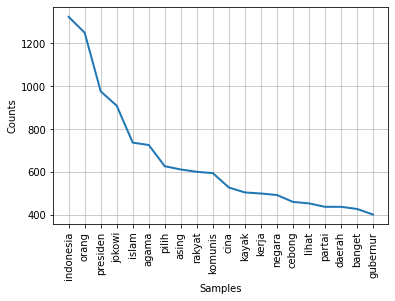

In [ ]:
fdict.plot(20)
plt.show()

In [ ]:
#change list to kalimat
def listToString(text): 
  return ' '.join(map(str, text))

spell_df['str_filtered'] = spell_df['text_filtering'].apply(listToString)

In [ ]:
spell_df.head()

,text_lemma,label,text_filtering,str_filtered
0,gue suka kontrol kamu sayang,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[suka, kontrol, sayang]",suka kontrol sayang
1,gila kamu dr pelepasan saham sama dengan prokl...,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]","[gila, dr, pelepasan, saham, proklamasi, merde...",gila dr pelepasan saham proklamasi merdeka sak...
2,sampai sekarang aku tak jumpa lagi maklumat pa...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[jumpa, maklumat, pasal, bangsa, parut, kat, m...",jumpa maklumat pasal bangsa parut kat muka per...
3,pak anies dan pak sandi mana kerja wkwk belum ...,"[1, 0, 0, 0, 0, 0, 1, 1, 0, 0]","[anies, sandi, kerja, apapa, tagih, mundur, ho...",anies sandi kerja apapa tagih mundur hormat
4,ini efek ajar bani cingkrang jidat hitam panta...,"[0, 1, 1, 0, 0, 0, 0, 0, 1, 0]","[efek, ajar, bani, cingkrang, jidat, hitam, pa...",efek ajar bani cingkrang jidat hitam pantat panci


In [ ]:
#save csv

spell_df.to_csv('data_cleaned.csv')